In [115]:
import requests
from urllib.request import urlopen
from urllib.parse import urlencode,unquote,quote_plus
import urllib
import lxml
import pandas as pd
import numpy as np
from bs4 import BeautifulSoup
import re
import time
from sklearn.cluster import DBSCAN
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import NearestNeighbors
from sklearn.cluster import KMeans
from sklearn.feature_extraction.text import TfidfVectorizer,CountVectorizer
from sklearn.manifold import TSNE
import seaborn as sns

In [2]:
info2_df = pd.read_excel("estate.xlsx")
info2_df.columns = ["ID","title","주문","이유"]
info2_df = info2_df.drop(info2_df[info2_df["이유"].isna()].index)
info2_df

,ID,title,주문,이유
0,6145,대구지방법원 2003. 12. 16 선고 2002가합15041 판결 [손해배상(기) ],"주 문\n1.피고는 원고에게 금 361,289,030원 및 이에 대하여 2002.1...","이 유1.기초사실\n다음 각 사실은 당사자 사이에 다툼이 없거나 갑 제1호증의 1,..."
1,4100,대전지방법원 2011. 6. 10 선고 2010가합11839 판결 [손해배상(기) ],"주 문\n1. 피고는 원고에게 41,122,400원 및 이에 대하여 2010. 11...",이 유1. 기초사실\n가. 디앤디산업개발 주식회사(이하 ‘디앤디산업개발’이라 한다)...
2,7,"서울중앙지방법원 2015. 6. 5 선고 2014가합536696, 2014가합569...","주 문\n1. 피고들은 공동하여,\n가. 원고 C에게 서울 서초구 J 철근콘크리트구...",이 유1. 기초사실가. 원고들은 아래와 같이 서울 서초구 K 소재 집합건물인 L(지...
3,8,의정부지방법원고양지원 2015. 2. 4 선고 2013가합5374 판결 [손해배상등...,【주 문】\n1. 원고(반소피고)의 본소청구 및 피고(반소원고)의 반소청구를 모두 ...,【이 유】1. 기초 사실가. 소외 1은 1997. 6. 24. 고양시 (주소 생략)...
4,6155,서울지방법원 2003. 11. 12 선고 2002가합3921 판결 [손해배상(기) ],주문\n1. 원고들 및 원고 석▲혜의 승계참가인의 피고들에 대한 청구를 모두 기각한...,"이유1.기초사실\n다음 사실은 당사자 사이에 다툼이 없거나, 갑 제1호증의 1,2,..."
...,...,...,...,...
662,2034,수원지방법원여주지원 2020. 3. 24 선고 2019가단54912 판결 [손해배상...,주문\n1. 원고의 청구를 기각한다.\n2. 소송비용은 원고가 부담한다.,이유1. 기초 사실가. 원고는 2014. 11. 19. 부친인 망 C로부터 여주시 ...
663,2035,서울중앙지방법원 2020. 3. 23 선고 2019가단5072287 판결 [손해배상...,"주문\n1. 피고는 원고에게 19,454,400원 및 이에 대하여 2017. 4. ...",이유1. 인정사실가. 원고는 다가구주택인 별지 목록 기재 부동산(이하 '이 사건 부...
664,6131,서울지방법원 2004. 1. 28 선고 2002가합86693 판결 [손해배상(기) ],주문\n1. 피고 곽ㅇㅇ은 원고에게 5억 원 및 이에 대한 2003. 1. 10.부...,"이유1. 기초사실\n[증거] 다툼없는 사실, 갑 2호증의 1, 2의 각 기재, 변론..."
665,2039,인천지방법원 2020. 2. 14 선고 2018가합58966 판결 [손해배상(기)],주문\n1. 원고들의 피고들에 대한 청구를 모두 기각한다.\n2. 소송비용은 원고들...,이유1. 기초사실가. 원고들1)\n은 2017. 3. 30. 피고들로부터 피고 D ...


In [167]:
df_mapping = pd.read_excel("1126_단어맵핑.xlsx")
input_data = "저는 상가 빌딩 내에서 음식점을 운영하고 있습니다. 임대차계약이 끝나기 전에 다른 사람이 제가 운영하는 음식점을 임차하기를 원해서 권리금을 받기로 하였지만 빌딩 주인이 그 과정에서 그 사람에게 여러 서류 제출을 요구하고 원래 세입자가 내는 돈보다 많이 돈을 내라고 하여 타협이 취소되었습니다. 저는 빌딩 주인이 권리금 돌려받는 것을 방해했다고 생각하여 손해배상을 청구하려 합니다."
df_mapping = df_mapping.dropna()
print(input_data)
for idx,i in enumerate(df_mapping["일반용어"]):
    temp = i.split(",")
    for j in temp:
        if len(j.strip()) ==0:
            continue
        if j.strip() in input_data:
            input_data = input_data.replace(j.strip(),df_mapping["부동산관련 법률용어"].iloc[idx].split("(")[0])
            print(j.strip(),"=>",df_mapping["부동산관련 법률용어"].iloc[idx].split("(")[0])
print(input_data)

    
df_mapping

저는 상가 빌딩 내에서 음식점을 운영하고 있습니다. 임대차계약이 끝나기 전에 다른 사람이 제가 운영하는 음식점을 임차하기를 원해서 권리금을 받기로 하였지만 빌딩 주인이 그 과정에서 그 사람에게 여러 서류 제출을 요구하고 원래 세입자가 내는 돈보다 많이 돈을 내라고 하여 타협이 취소되었습니다. 저는 빌딩 주인이 권리금 돌려받는 것을 방해했다고 생각하여 손해배상을 청구하려 합니다.
주인 => 매수인
세입자 => 임차인
돈 => 비용
빌딩 => 건물
끝나기 => 종료되기
타협 => 협의
원래 => 기존
저는 상가 건물 내에서 음식점을 운영하고 있습니다. 임대차계약이 종료되기 전에 다른 사람이 제가 운영하는 음식점을 임차하기를 원해서 권리금을 받기로 하였지만 건물 매수인이 그 과정에서 그 사람에게 여러 서류 제출을 요구하고 기존 임차인가 내는 비용보다 많이 비용을 내라고 하여 협의이 취소되었습니다. 저는 건물 매수인이 권리금 돌려받는 것을 방해했다고 생각하여 손해배상을 청구하려 합니다.


,부동산관련 법률용어,일반용어
0,의무(135),"해야하는 일, 하여야 할 일, 했어야 하는 일, 했어야 했는데, 해야하는데, 해야되..."
1,행위(135),"행동, 활동, 의식적인 활동, 동작"
2,채권자(131),"돈을 받아야하는 사람, 돈을 받을 권리가 있는 사람, 청구할 수 있는 권리를 가진 ..."
3,처분(124),"처리, 처리하여 치우는 것, 처리하여 치우는, 지시, 결정, 법규를 적용하는 것, ..."
4,매수인(122),"넘겨받은 사람, 물건을 산 사람, 건물을 산 사람, 주인, 주인이 된 사람, 구매자..."
5,담보(118),"맡아서 보증한느 것, 맡아서 보증함, 맡아서 보증, 보증, 변제 확보를 위한 것, ..."
6,가압류(100),"재산을 임시로 확보하는 일, 재산을 임시로 확보, 재산 임시 확보, 채권자를 위한 ..."
7,매도인(93),"재산권의 의무를 갖는, 재산권 의무, 재산권 의무를 갖는 사람, 건물을 파는 사람,..."
8,근저당(81),"채권의 담보를 미리 설정, 채권 담보 설정, 채권의 담보, 채무를 이행하지 않을 경..."
9,과실(100),"잘못, 부주의, 허물, 몰랐던, 미리 몰랐던, 예기치 못하게, 의도하지 않은, 태만..."


In [4]:
info_df = pd.read_excel("부동산.xlsx")
info_df = pd.concat([info2_df,info_df])
info_df.reset_index()
input_df = pd.Series([0,"","",input_data],index = ["ID","참조조문","주문","이유"])
info_df = info_df.append(input_df,ignore_index= True)
info_df

,ID,title,주문,이유,참조조문
0,6145,대구지방법원 2003. 12. 16 선고 2002가합15041 판결 [손해배상(기) ],"주 문\n1.피고는 원고에게 금 361,289,030원 및 이에 대하여 2002.1...","이 유1.기초사실\n다음 각 사실은 당사자 사이에 다툼이 없거나 갑 제1호증의 1,...",NaN
1,4100,대전지방법원 2011. 6. 10 선고 2010가합11839 판결 [손해배상(기) ],"주 문\n1. 피고는 원고에게 41,122,400원 및 이에 대하여 2010. 11...",이 유1. 기초사실\n가. 디앤디산업개발 주식회사(이하 ‘디앤디산업개발’이라 한다)...,NaN
2,7,"서울중앙지방법원 2015. 6. 5 선고 2014가합536696, 2014가합569...","주 문\n1. 피고들은 공동하여,\n가. 원고 C에게 서울 서초구 J 철근콘크리트구...",이 유1. 기초사실가. 원고들은 아래와 같이 서울 서초구 K 소재 집합건물인 L(지...,NaN
3,8,의정부지방법원고양지원 2015. 2. 4 선고 2013가합5374 판결 [손해배상등...,【주 문】\n1. 원고(반소피고)의 본소청구 및 피고(반소원고)의 반소청구를 모두 ...,【이 유】1. 기초 사실가. 소외 1은 1997. 6. 24. 고양시 (주소 생략)...,NaN
4,6155,서울지방법원 2003. 11. 12 선고 2002가합3921 판결 [손해배상(기) ],주문\n1. 원고들 및 원고 석▲혜의 승계참가인의 피고들에 대한 청구를 모두 기각한...,"이유1.기초사실\n다음 사실은 당사자 사이에 다툼이 없거나, 갑 제1호증의 1,2,...",NaN
...,...,...,...,...,...
1003,73698,NaN,원고의 항소 및 당심에서의 확장청구 및 예비적 청구를 모두 기각한다. 항소비용 및...,중앙도매시장 업무대행권의 재위임계약이 무효인지의 여부와 그 계약위반으로 인한 손해배...,"중앙도매시장법 제3조\n, \n 제5조\n, \n 제6조의..."
1004,74272,NaN,1. 원판결을 다음과 같이 변경한다. 피고(반소원고)는 원고(반소피고)에게 돈...,토지구획정리사업 시행 이전부터 도로에 공한 토지에 대하여 환지의 지정되 아니하고 ...,"민법 제750조\n, \n 토지구획정리사업법 제52조\n, \n ..."
1005,76017,NaN,피고가 1982. 7. 28. 원고들의 별지목록기재 토지에 대한 손실보상재결 신청을...,1. 서울특별시장이 행하는 하천제방축조공사에 따른 손실보상의 관할토지수용위원회2. ...,"토지수용법 제28조, \n 토지수용법 제35조, \n 구 ..."
1006,76581,NaN,"피고(반소원고)의 항소를 모두 기각한다. 항소비용은 본소, 반소를 통하여 모두 피...",임대인의 승낙이 있는 전대차의 경우 임대인과 전차인의 법률관계 임대인이 전대를 승낙...,"민법 제629조\n\n, \n 제630조"


In [47]:
info_df.drop_duplicates(['ID'])
info_df

,ID,title,주문,이유,참조조문
0,6145,대구지방법원 2003. 12. 16 선고 2002가합15041 판결 [손해배상(기) ],"주 문\n1.피고는 원고에게 금 361,289,030원 및 이에 대하여 2002.1...","이 유1.기초사실\n다음 각 사실은 당사자 사이에 다툼이 없거나 갑 제1호증의 1,...",NaN
1,4100,대전지방법원 2011. 6. 10 선고 2010가합11839 판결 [손해배상(기) ],"주 문\n1. 피고는 원고에게 41,122,400원 및 이에 대하여 2010. 11...",이 유1. 기초사실\n가. 디앤디산업개발 주식회사(이하 ‘디앤디산업개발’이라 한다)...,NaN
2,7,"서울중앙지방법원 2015. 6. 5 선고 2014가합536696, 2014가합569...","주 문\n1. 피고들은 공동하여,\n가. 원고 C에게 서울 서초구 J 철근콘크리트구...",이 유1. 기초사실가. 원고들은 아래와 같이 서울 서초구 K 소재 집합건물인 L(지...,NaN
3,8,의정부지방법원고양지원 2015. 2. 4 선고 2013가합5374 판결 [손해배상등...,【주 문】\n1. 원고(반소피고)의 본소청구 및 피고(반소원고)의 반소청구를 모두 ...,【이 유】1. 기초 사실가. 소외 1은 1997. 6. 24. 고양시 (주소 생략)...,NaN
4,6155,서울지방법원 2003. 11. 12 선고 2002가합3921 판결 [손해배상(기) ],주문\n1. 원고들 및 원고 석▲혜의 승계참가인의 피고들에 대한 청구를 모두 기각한...,"이유1.기초사실\n다음 사실은 당사자 사이에 다툼이 없거나, 갑 제1호증의 1,2,...",NaN
...,...,...,...,...,...
1003,73698,NaN,원고의 항소 및 당심에서의 확장청구 및 예비적 청구를 모두 기각한다. 항소비용 및...,중앙도매시장 업무대행권의 재위임계약이 무효인지의 여부와 그 계약위반으로 인한 손해배...,"중앙도매시장법 제3조\n, \n 제5조\n, \n 제6조의..."
1004,74272,NaN,1. 원판결을 다음과 같이 변경한다. 피고(반소원고)는 원고(반소피고)에게 돈...,토지구획정리사업 시행 이전부터 도로에 공한 토지에 대하여 환지의 지정되 아니하고 ...,"민법 제750조\n, \n 토지구획정리사업법 제52조\n, \n ..."
1005,76017,NaN,피고가 1982. 7. 28. 원고들의 별지목록기재 토지에 대한 손실보상재결 신청을...,1. 서울특별시장이 행하는 하천제방축조공사에 따른 손실보상의 관할토지수용위원회2. ...,"토지수용법 제28조, \n 토지수용법 제35조, \n 구 ..."
1006,76581,NaN,"피고(반소원고)의 항소를 모두 기각한다. 항소비용은 본소, 반소를 통하여 모두 피...",임대인의 승낙이 있는 전대차의 경우 임대인과 전차인의 법률관계 임대인이 전대를 승낙...,"민법 제629조\n\n, \n 제630조"


In [6]:
posts = info_df.get("이유")
posts

0       이 유1.기초사실\n다음 각 사실은 당사자 사이에 다툼이 없거나 갑 제1호증의 1,...
1       이 유1. 기초사실\n가. 디앤디산업개발 주식회사(이하 ‘디앤디산업개발’이라 한다)...
2       이 유1. 기초사실가. 원고들은 아래와 같이 서울 서초구 K 소재 집합건물인 L(지...
3       【이 유】1. 기초 사실가. 소외 1은 1997. 6. 24. 고양시 (주소 생략)...
4       이유1.기초사실\n다음 사실은 당사자 사이에 다툼이 없거나, 갑 제1호증의 1,2,...
                              ...                        
1003    중앙도매시장 업무대행권의 재위임계약이 무효인지의 여부와 그 계약위반으로 인한 손해배...
1004    토지구획정리사업 시행 이전부터 도로에 공한 토지에 대하여 환지의 지정되 아니하고  ...
1005    1. 서울특별시장이 행하는 하천제방축조공사에 따른 손실보상의 관할토지수용위원회2. ...
1006    임대인의 승낙이 있는 전대차의 경우 임대인과 전차인의 법률관계 임대인이 전대를 승낙...
1007    저는 상가 건물 내에서 음식점을 운영하고 있습니다. 임대차계약이 종료되기 전에 다른...
Name: 이유, Length: 1008, dtype: object

In [7]:
from konlpy.tag import Mecab
tagger = Mecab()
# 불용어 리스트
# 불용어, 불필요 단어 제거
stop_words_df = pd.read_excel("stopwords.xlsx")
stop_words_df

,불용어
0,아
1,휴
2,아이구
3,아이쿠
4,아이고
...,...
717,더욱이
718,도달
719,돼다
720,되다


In [8]:
# 명사부분 추출
nouns = []
for post in posts:
    for noun in tagger.nouns(post):
        if noun not in list(stop_words_df.get("불용어")):
            nouns.append(noun)
nouns[0:10]


['유', '기초', '사실', '당사자', '사이', '갑', '갑', '내지', '갑', '내지']

In [9]:
len(nouns)

664245

In [10]:
# 가장많이 나오는 명사 상위 20개
from collections import Counter
num_top_nouns = 200
nouns_counter = Counter(nouns)
top_nouns = dict(nouns_counter.most_common(num_top_nouns)[:200])
top_nouns
# print(len(counted_nouns))

{'원고': 23771,
 '사건': 20977,
 '원': 12370,
 '피고': 12009,
 '계약': 7500,
 '손해': 7240,
 '건물': 5706,
 '사실': 5702,
 '인정': 5626,
 '토지': 5565,
 '주장': 4682,
 '지급': 4453,
 '청구': 4207,
 '부동산': 4123,
 '기재': 4065,
 '배상': 3923,
 '중': 3740,
 '소유': 3715,
 '등기': 3706,
 '이유': 3601,
 '임대차': 3601,
 '의무': 3470,
 '공사': 3334,
 '책임': 3190,
 '판결': 2983,
 '금': 2819,
 '만': 2818,
 '아파트': 2812,
 '체결': 2772,
 '발생': 2767,
 '이하': 2753,
 '매매': 2715,
 '갑': 2648,
 '사업': 2590,
 '부분': 2581,
 '김': 2524,
 '주택': 2519,
 '이전': 2354,
 '내지': 2342,
 '회사': 2287,
 '취지': 2230,
 '분양': 2211,
 '상당': 2206,
 '소외': 2204,
 '행위': 2147,
 '사이': 2141,
 '내용': 1974,
 '사정': 1872,
 '날': 1872,
 '법원': 1833,
 '억': 1806,
 '확인': 1804,
 '당시': 1794,
 '규정': 1750,
 '중개': 1733,
 '대금': 1683,
 '판단': 1666,
 '변론': 1654,
 '감정': 1612,
 '경': 1592,
 '사용': 1590,
 '기간': 1565,
 '법': 1538,
 '선고': 1520,
 '건축': 1518,
 '소송': 1511,
 '임차인': 1495,
 '결과': 1486,
 '시': 1459,
 '증거': 1424,
 '명의': 1417,
 '비용': 1417,
 '전체': 1413,
 '근저당': 1407,
 '채권': 1405,
 '종합': 1392,
 '처분': 1381,
 

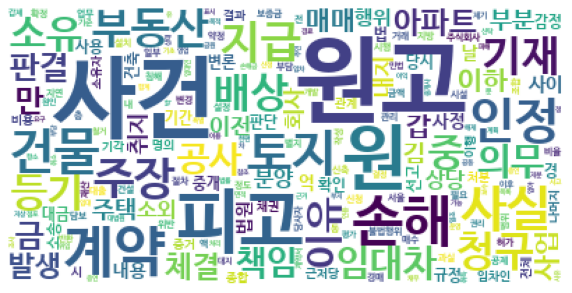

In [11]:
# wordcloud 패키지 다운로드
!pip install wordcloud
from wordcloud import WordCloud
wc = WordCloud(background_color="white", font_path='/Users/byeonghyeon/Documents/GitHub/IndustrialSystemsEngineering_Project/font/NanumBarunGothicBold.ttf')
wc.generate_from_frequencies(top_nouns)
# World
# 많이 나타나는 단어일수록 크게 나타남
import matplotlib.pyplot as plt
figure = plt.figure()
figure.set_size_inches(10, 10)
ax = figure.add_subplot(1, 1, 1)
ax.axis("off")
ax.imshow(wc)

In [12]:
from konlpy.tag import Okt
okt = Okt()

oo = okt.pos(posts.iloc[0],
        norm=True,   # 정규화(normalization)
        stem=True    # 어간추출(stemming)
        )

print(oo)

[('이', 'Noun'), ('유', 'Noun'), ('1', 'Number'), ('.', 'Punctuation'), ('기초', 'Noun'), ('사실', 'Noun'), ('\n', 'Foreign'), ('다음', 'Noun'), ('각', 'Noun'), ('사실', 'Noun'), ('은', 'Josa'), ('당사자', 'Noun'), ('사이', 'Noun'), ('에', 'Josa'), ('다툼', 'Noun'), ('이', 'Josa'), ('없다', 'Adjective'), ('갑', 'Noun'), ('제', 'Noun'), ('1', 'Number'), ('호증', 'Noun'), ('의', 'Josa'), ('1', 'Number'), (',', 'Punctuation'), ('2', 'Number'), (',', 'Punctuation'), ('갑', 'Noun'), ('제', 'Noun'), ('2', 'Number'), ('호증', 'Noun'), (',', 'Punctuation'), ('갑', 'Noun'), ('제', 'Noun'), ('3', 'Number'), ('호증', 'Noun'), ('의', 'Josa'), ('1', 'Number'), ('내지', 'Noun'), ('3', 'Number'), (',', 'Punctuation'), ('갑', 'Noun'), ('제', 'Noun'), ('4', 'Number'), ('내지', 'Noun'), ('제', 'Noun'), ('6', 'Number'), ('호증', 'Noun'), (',', 'Punctuation'), ('갑', 'Noun'), ('제', 'Noun'), ('10', 'Number'), (',', 'Punctuation'), ('14', 'Number'), ('호증', 'Noun'), ('의', 'Josa'), ('각', 'Noun'), ('1', 'Number'), (',', 'Punctuation'), ('2', 'Number'), (',

In [13]:
# 첫번째 tokenizer(Okt)
def tokenizer_1(raw_texts, pos=["Noun","Alpha","Verb","Number"], stop_words=list(stop_words_df.get("불용어"))):
    p = okt.pos(raw_texts, 
            norm=True,   # 정규화(normalization)
            stem=True    # 어간추출(stemming)
            )
    o = [word for word, tag in p if len(word) > 1 and tag in pos and word[0] not in stop_words]
    return(o)

print(posts.iloc[-1])
print(tokenizer_1(posts.iloc[-1]))

저는 상가 건물 내에서 음식점을 운영하고 있습니다. 임대차계약이 종료되기 전에 다른 사람이 제가 운영하는 음식점을 임차하기를 원해서 권리금을 받기로 하였지만 건물 매수인이 그 과정에서 그 사람에게 여러 서류 제출을 요구하고 기존 임차인가 내는 비용보다 많이 비용을 내라고 하여 협의이 취소되었습니다. 저는 건물 매수인이 권리금 돌려받는 것을 방해했다고 생각하여 손해배상을 청구하려 합니다.
['상가', '건물', '음식점', '임대차', '계약', '종료', '되다', '다른', '음식점', '임차', '권리금', '받다', '건물', '서류', '요구', '기존', '임차', '내다', '비용', '비용', '협의', '취소', '되어다', '건물', '권리금', '돌리다', '받다', '방해', '생각', '손해배상', '청구']


In [14]:
# 첫번째 tokenizer(Okt)
def tokenizer_3(raw_texts, pos=["Noun"], stop_words=list(stop_words_df.get("불용어"))):
    p = okt.pos(raw_texts, 
            norm=True,   # 정규화(normalization)
            stem=True    # 어간추출(stemming)
            )
    o = [word for word, tag in p if len(word) > 1 and tag in pos and word[0] not in stop_words]
    return(o)

print(posts.iloc[-1])
print(tokenizer_3(posts.iloc[-1]))

저는 상가 건물 내에서 음식점을 운영하고 있습니다. 임대차계약이 종료되기 전에 다른 사람이 제가 운영하는 음식점을 임차하기를 원해서 권리금을 받기로 하였지만 건물 매수인이 그 과정에서 그 사람에게 여러 서류 제출을 요구하고 기존 임차인가 내는 비용보다 많이 비용을 내라고 하여 협의이 취소되었습니다. 저는 건물 매수인이 권리금 돌려받는 것을 방해했다고 생각하여 손해배상을 청구하려 합니다.
['상가', '건물', '음식점', '임대차', '계약', '종료', '다른', '음식점', '임차', '권리금', '건물', '서류', '요구', '기존', '임차', '비용', '비용', '협의', '취소', '건물', '권리금', '방해', '생각', '손해배상', '청구']


In [15]:
# 두번째 tokenizer(mecab)
def tokenizer_2(raw_texts, pos=["Noun","Alpha","Verb","Number"], stop_words=list(stop_words_df.get("불용어"))):
    nouns = []
  
    for noun in tagger.nouns(raw_texts):
        if noun not in stop_words and len(noun)>1:
            nouns.append(noun)
    return nouns
print(posts.iloc[-1])
print(tokenizer_2(posts.iloc[-1]))

저는 상가 건물 내에서 음식점을 운영하고 있습니다. 임대차계약이 종료되기 전에 다른 사람이 제가 운영하는 음식점을 임차하기를 원해서 권리금을 받기로 하였지만 건물 매수인이 그 과정에서 그 사람에게 여러 서류 제출을 요구하고 기존 임차인가 내는 비용보다 많이 비용을 내라고 하여 협의이 취소되었습니다. 저는 건물 매수인이 권리금 돌려받는 것을 방해했다고 생각하여 손해배상을 청구하려 합니다.
['상가', '건물', '음식점', '운영', '임대차', '계약', '종료', '사람', '운영', '음식점', '임차', '권리금', '건물', '매수인', '과정', '사람', '서류', '제출', '요구', '기존', '차인가', '비용', '비용', '협의', '취소', '건물', '매수인', '권리금', '방해', '생각', '손해', '배상', '청구']


In [34]:
vectorize = TfidfVectorizer(
    tokenizer = tokenizer_2, # 문장에 대한 tokenizer (위에 정의한 함수 이용)
    min_df = 10,            # 단어가 출현하는 최소 문서의 개수
    sublinear_tf = True,    # tf값에 1+log(tf)를 적용하여 tf값이 무한정 커지는 것을 막음
    stop_words = list(stop_words_df.get("불용어"))
)

X = vectorize.fit_transform(posts)
pd.DataFrame(X.toarray())

/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_extraction/text.py:383: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['개의', '거니', '결과', '고려', '고용', '공동', '관계', '구체', '구토', '근거', '기관', '기점', '기준', '나다', '나머지', '노동', '노동부', '대로', '도착', '동시', '따름', '때문', '마음', '방면', '부령', '부류', '불문', '비교', '사람', '상대', '생각', '서술', '시작', '시초', '아래', '아무', '연관', '의거', '의지', '이외', '이용', '이유', '일반', '일지', '입각', '입장', '정도', '제외', '종합', '주저', '즈음', '지경', '진짜', '필요', '한적', '할만', '항목', '행정', '형식'] not in stop_words.
  warnings.warn('Your stop_words may be inconsistent with '


,0,1,2,3,4,5,6,7,8,9,...,2197,2198,2199,2200,2201,2202,2203,2204,2205,2206
0,0.0,0.0,0.0,0.055620,0.037214,0.0,0.0,0.0,0.000000,0.0,...,0.051778,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,...,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.048624,0.000000,0.0,0.0,0.0,0.000000,0.0,...,0.000000,0.0,0.057549,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,...,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.058226,0.000000,0.0,0.0,0.0,0.053562,0.0,...,0.000000,0.0,0.054145,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1003,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,...,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1004,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,...,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1005,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,...,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1006,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,...,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [35]:
tfidf_df = pd.DataFrame(X.toarray())
# tfidf_df = pd.read_excel("TF-IDF_vectors.xlsx")
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics.pairwise import euclidean_distances
# 2번째와 3번째 문서(유클리디안 거리 값)
print(euclidean_distances(X[1], X[2]))#, X)
# 2번째와 3번째 문서(코사인유사도 값)
print(cosine_similarity(X[1], X[0]))#, X)
# [[0.1837195]]

[[1.27554928]]
[[0.21881671]]


In [36]:
# target_id 와 유사한 판례를 cosine_similarity으로 계산하여 유사벡터 도출
# 약 1분 소요
cosine_result = {}
error_reslut = {}
target_id = 0
x = info_df[info_df['ID'] == target_id].index[0]  # target_id의 Id값의 index

for y in range(len(info_df)):
    try:
        cosine_result[info_df['ID'].iloc[y]] = cosine_similarity(X[x], X[y])[0][0]
#         print(x,y,cosine_similarity(X[x], X[y]))
    except:
        error_reslut[info_df["ID"].iloc[y]] = cosine_similarity(X[x], X[y])
        print("error",x,y,cosine_similarity(X[x], X[y]))
sorted_cosine_dic = sorted(cosine_result.items(), key = lambda x:x[1], reverse = True)

# cosine_similariry 값 기준으로 내림차순 정렬된 유사 판례들
# 먼저나올수록 유사한 판례이다.
sorted_cosine_dic[0:11]

[(0, 1.0),
 (186151, 0.3932336320458871),
 (183476, 0.3862957247339755),
 (2586, 0.3456218427727562),
 (2680, 0.3244081935687671),
 (185123, 0.3205876001883988),
 (8038, 0.31535213940094137),
 (2462, 0.2834198066069739),
 (2723, 0.2828645386563019),
 (2798, 0.2821073375663717),
 (2634, 0.27769817854644424)]

In [109]:
# cosine_result = []
# for x in range(len(info_df)):
#     tmp = []
#     for y in range(len(info_df)):
#         tmp.append(cosine_similarity(X[x], X[y])[0][0])
#     cosine_result.append(tmp)
# cosine_result

simMatrix = []
for i in sorted_cosine_dic[0:11]:
    print(info_df[info_df["ID"] == i[0]].index[0])
    

# cosine_similarity(X[0], X[1007])

1007
873
874
218
259
875
622
157
275
297
240


In [168]:
id_list = [i[0] for i in sorted_cosine_dic[0:11]]
for i in sorted_cosine_dic[0:11]:
    for j in str(info_df[info_df["ID"]==i[0]]["참조조문"].iloc[0]).split(","):
        if j.strip() =="nan":
            continue
        print(j.strip())
#     print("*"*10)
    print()



상가건물 임대차보호법 제2조
제10조
제10조의3
제10조의4 제1항
제2항
제3항
제5항
부칙(2015. 5. 13.) 제1조
제2조
제3조

상가건물 임대차보호법 제10조의4



상가건물 임대차보호법 제10조 제1항
제2항
제10조의4 제1항 제4호
제3항








In [50]:
cnt_기각 = 0
cnt_승소 = 0
cnt_일부승소 = 0
id_list = [i[0] for i in sorted_cosine_dic[1:11]]
for i in sorted_cosine_dic[1:11]:
    print(info_df[info_df["ID"]==i[0]]["주문"].iloc[0])
    if '나머지 청구를 기각한다' in info_df[info_df["ID"]==i[0]]["주문"].iloc[0] or "나머지 항소를 기각한다" in info_df[info_df["ID"]==i[0]]["주문"].iloc[0] or "나머지 청구" in info_df[info_df["ID"]==i[0]]["주문"].iloc[0] or "지급하라" in info_df[info_df["ID"]==i[0]]["주문"].iloc[0]:
        print("결과 : 일부승소")
        cnt_일부승소 += 1
    elif "기각" in info_df[info_df["ID"]==i[0]]["주문"].iloc[0]:
        print("결과 : 기각")
        cnt_기각 += 1
    else:
        print("결과 : 승소")
        cnt_승소 += 1
    print()

print("기각 :{}건\n승소 : {}건\n일부 승소 {}건".format(cnt_기각,cnt_승소,cnt_일부승소)) 


  1.  제1심판결을 취소한다.  2.  원고(반소피고, 선정당사자)와 선정자 2의 피고(반소원고)에 대한 별지 1 목록 기재 건물의 1층 중 별지 2 도면 표시 가, 나, 다, 라의 각 점을 차례로 연결한 선내 부분 118.8㎡를 인도함에 따른 권리금, 손해배상금 및 이에 대한 이자 등 일체의 채무는 존재하지 아니함을 확인한다.  3.  피고(반소원고)의 반소청구를 기각한다.  4.  소송총비용은 피고(반소원고)가 부담한다.
결과 : 기각

 1. 원고(반소피고, 선정당사자)와 선정자 2는 공동하여 피고(반소원고)에게 89,870,000원 및 이에 대하여 2016. 6. 28.부터 다 갚는 날까지 연 15%의 비율로 계산한 금원을 지급하라. 2. 원고(반소피고, 선정당사자)의 본소청구를 기각한다. 3. 소송비용은 본소와 반소를 합하여 원고(반소피고, 선정당사자)가 부담한다. 4. 제1항은 가집행할 수 있다.
결과 : 일부승소

주문
1. 원고의 청구를 기각한다.
2. 소송비용은 원고가 부담한다.
결과 : 기각

주문
1. 원고의 청구를 기각한다.
2. 소송비용은 원고가 부담한다.
결과 : 기각

  1.  제1심판결 중 반소에 대한 부분 중 아래에서 지급을 명하는 금액에 해당하는 피고(반소원고) 패소 부분을 취소한다.  2.  원고(반소피고)들은 연대하여 피고(반소원고)에게 22,390,000원 및 이에 대한 2015. 10. 7.부터 2017. 5. 19.까지는 연 5%, 그 다음 날부터 다 갚는 날까지는 연 15%의 각 비율로 계산한 돈을 지급하라.  3.  피고(반소원고)의 본소에 대한 항소 및 반소에 대한 나머지 항소를 모두 기각한다.  4.  본소에 대한 항소비용은 피고(반소원고)가 부담하고, 반소에 대한 소송총비용 중 1/5은 원고(반소피고)들이, 4/5는 피고(반소원고)가 각 부담한다.  5.  제2항은 가집행할 수 있다.
결과 : 일부승소

판결선고 2009. 11. 20
결과 : 승소

주문
1. 원고의 청구를 기각한다.
2. 소송비용은 원

In [44]:
for i in info_df[info_df["ID"] == 2586]["이유"]:
    print(i)

이유1. 기초사실가. 원고는 2003. 1. 10. C으로부터 울산 남구 D 소재 상가 101호(이하 '이 사건 상가'라고 한다)를 임대차기간 2년, 임차보증금 2,000만 원, 차임 월 100만 원으로 정하여 임차하였다(이하 '이 사건 임대차계약'이라 한다).나. 원고는 2012. 1. 30. C과 이 사건 임대차계약의 임차보증금을 2,500만 원으로 증액하고, 임대차기간을 2014. 10.30.까지로 하는 임대차계약서를 다시 작성하였다.다. 피고는 2014. 10. 11. C으로부터 이 사건 상가를 매수하고 2014. 10. 31. 위 건물에 관해 자기 앞으로 소유권이전등기를 마쳤다.라. 이 사건 임대차계약은 2014. 10. 31.경 갱신되어 2015. 10. 30. 기간만료로 종료되었다.[인정 근거] 다툼 없는 사실, 갑 제1호증, 을 제1호증의 각 기재, 변론 전체의 취지2. 판단가. 당사자들의 주장
1) 원고의 주장
원고는 이 사건 임대차계약이 종료되기 전 피고에게 신규임차인과 임대차계약을 체결할 것을 요청하였으나, 피고가 이를 거절하였다. 따라서 피고는 원고에게 상가건물 임대차보호법 제10조의 4에 따라 원고에게 신규임차인이 지급하려고 했던 권리금 상당액인 4,500만 원 및 이에 대한 지연손해금을 지급할 의무가 있다.
2) 피고의 주장
- 원고와 C이 최초 체결한 임대차계약에서 '임대인은 본 부동산에 대하여 권리금 및 시설비용을 인정하지 않는다'고 정하였으므로, 원고가 권리금 회수를 목적으로 제기한 이 사건 청구는 받아들여져서는 안 된다.
- 원고는 피고에게 신규임차인으로 소개할 E의 휴대폰번호만 알려주었을 뿐 보증금 및 차임을 지급할 자력 등에 관하여는 정보를 제공하지 않았다.
- 피고가 이 사건 상가를 매수한 뒤 원고에게 이 사건 임대차계약 기간을 1년 연장하여 주면서 피고가 위 건물에서 정육점을 운영할 예정이라는 사실을 고지하였는바, 위 사정들을 종합하여 보면 원고는 위 임대차계약 종료시 신규임차인 주선을 포기하였다고 보아야 한다.
- 피고

# DBSCAN

1.2935903301527636


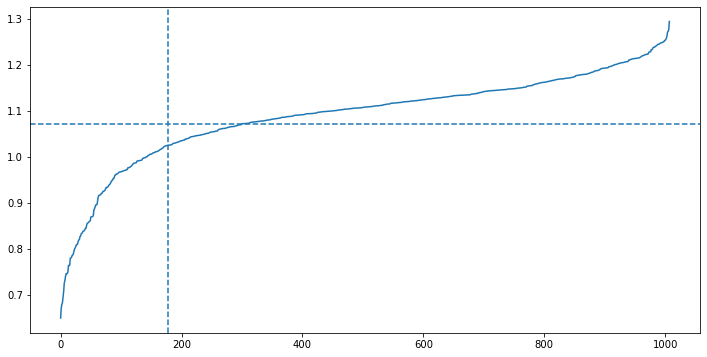

In [19]:
neigh = NearestNeighbors(n_neighbors=5)
neigh.fit(X)
distances, indices = neigh.kneighbors(X)
plt.figure(figsize=(12, 6))
plt.plot(np.sort(distances[:, 4]))
plt.axvline(178, 0, 2, ls='--')
plt.axhline(1.07, 0, 200, ls='--')
print(np.sort(distances[:, 4])[1007])

In [20]:
dbscan = DBSCAN(eps = 0.5, min_samples=5)
ss = StandardScaler()
scaled_df = pd.DataFrame(ss.fit_transform(tfidf_df))
# dbscan = DBSCAN(eps = 0.5)
dbscan_cluster = dbscan.fit_predict(scaled_df)
dbscan_cluster

array([-1, -1, -1, ..., -1, -1, -1])

In [21]:
# 군집화 된 패키지들을 DataFrame에 잘 들어가도록 전처리

dbscan_clustered_dic = {}
dbscan_clustered_list = []
dbscan_cluster_num = len(set(dbscan_cluster))
for idx,i in enumerate(dbscan_cluster):
    if i not in dbscan_clustered_dic:
        dbscan_clustered_dic[i] = [info_df['ID'].iloc[idx]]
    else:
        dbscan_clustered_dic[i].append(info_df['ID'].iloc[idx])
dbscan_clustered_dic
# 클러스터링이 된 패키지들
# 20개의 군집으로 생성

dbscan_clustered_dic = sorted(dbscan_clustered_dic.items(), key=lambda x: x[0])
dbscan_clustered_dic

[(-1,
  [6145,
   4100,
   7,
   8,
   6155,
   2060,
   2065,
   4116,
   2072,
   25,
   6170,
   31,
   4133,
   2087,
   50,
   6196,
   6205,
   4158,
   6206,
   4160,
   6207,
   66,
   6209,
   6213,
   2120,
   4171,
   2126,
   6224,
   88,
   89,
   4187,
   2143,
   4198,
   4203,
   4204,
   6252,
   6261,
   6265,
   4221,
   2180,
   139,
   141,
   6286,
   144,
   2193,
   6291,
   2196,
   6294,
   4253,
   162,
   2211,
   4262,
   167,
   2215,
   6312,
   6315,
   4270,
   6320,
   6322,
   2227,
   180,
   6323,
   4279,
   184,
   6328,
   6331,
   4289,
   4290,
   6337,
   6338,
   4293,
   4294,
   6340,
   200,
   4296,
   204,
   4300,
   4304,
   6354,
   6357,
   4314,
   220,
   2272,
   6371,
   2276,
   4326,
   4327,
   234,
   4331,
   236,
   6380,
   4337,
   2292,
   2293,
   6392,
   255,
   4351,
   257,
   6400,
   4356,
   262,
   263,
   6408,
   265,
   4365,
   2318,
   4367,
   272,
   6417,
   4378,
   4381,
   2335,
   4385,
   290,
   43

In [22]:
df_dbscan_cluster = pd.DataFrame(dbscan_clustered_dic,columns=['num','clusters'])
dbscan_cluster_num = [len(i) for i in df_dbscan_cluster['clusters']]
df_dbscan_cluster['cluster_num'] = dbscan_cluster_num
df_dbscan_cluster

,num,clusters,cluster_num
0,-1,"[6145, 4100, 7, 8, 6155, 2060, 2065, 4116, 207...",1008


# t-sne

In [23]:
m = TSNE(learning_rate = 50)
tsne_features = m.fit_transform(pd.DataFrame(X.toarray()))
tsne_features

array([[ -3.4276254 ,  -1.5769558 ],
       [  8.303675  ,  -4.089637  ],
       [ 42.197716  ,  -9.255525  ],
       ...,
       [ 10.928392  , -17.530212  ],
       [ -8.504677  , -30.589529  ],
       [  0.20180054, -42.91083   ]], dtype=float32)

In [24]:
df = pd.DataFrame()
df['x'] = tsne_features[:,0]
df['y'] = tsne_features[:,1]

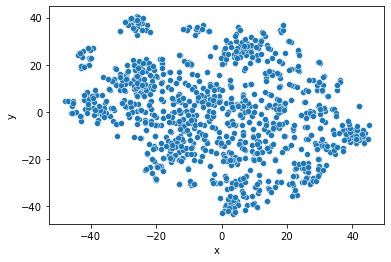

In [25]:
sns.scatterplot(x="x",y="y",data = df)
plt.show()

In [135]:
tsne_features

array([[ -3.4276254 ,  -1.5769558 ],
       [  8.303675  ,  -4.089637  ],
       [ 42.197716  ,  -9.255525  ],
       ...,
       [ 10.928392  , -17.530212  ],
       [ -8.504677  , -30.589529  ],
       [  0.20180054, -42.91083   ]], dtype=float32)

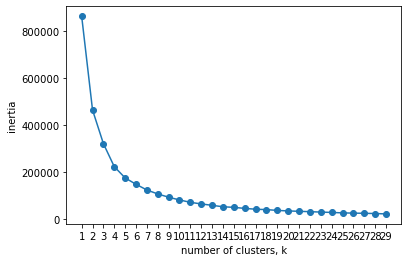

In [27]:
ks = range(1,30)

inertias = []

for k in ks:
    model = KMeans(n_clusters=k)
    model.fit(tsne_features)
    inertias.append(model.inertia_)
# Plot ks vs inertias
plt.plot(ks, inertias, '-o')
plt.xlabel('number of clusters, k')
plt.ylabel('inertia')
plt.xticks(ks)
plt.show()


In [65]:
n_clusters = 5
kmeans = KMeans(n_clusters=n_clusters)
# kmeans = KMeans(n_clusters=4,verbose = 1)
kmeans

# 모델에 fitting 하기
kmeans.fit(tsne_features)

y_kmeans = kmeans.predict(tsne_features)
y_kmeans[0:10] # 군집화 된 결과


array([2, 2, 1, 2, 1, 1, 0, 0, 2, 2], dtype=int32)

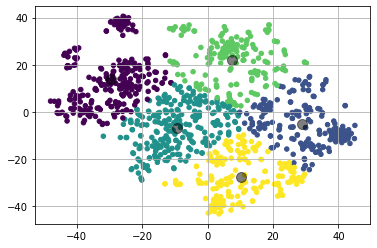

In [76]:
plt.scatter(np.array(tsne_features)[:,0], np.array(tsne_features)[:,1], c=y_kmeans, s=20, cmap='viridis')
centers = kmeans.cluster_centers_
plt.scatter(centers[:,0], centers[:,1], c='black', s=100, alpha=0.5)
plt.grid()
plt.show()


In [68]:
# 군집화 된 패키지들을 DataFrame에 잘 들어가도록 전처리

clustered_dic = {}
clustered_list = []
cluster_num = len(set(y_kmeans))
for idx,i in enumerate(y_kmeans):
    if i not in clustered_dic:
        clustered_dic[i] = [info_df['ID'].iloc[idx]]
    else:
        clustered_dic[i].append(info_df['ID'].iloc[idx])
clustered_dic
# 클러스터링이 된 패키지들
# 20개의 군집으로 생성

clustered_dic = sorted(clustered_dic.items(), key=lambda x: x[0])
clustered_dic

[(0,
  [2065,
   4116,
   31,
   4160,
   66,
   6209,
   4203,
   6252,
   141,
   6291,
   162,
   6323,
   184,
   6331,
   4289,
   4296,
   4300,
   6357,
   6371,
   2276,
   236,
   6392,
   265,
   4387,
   292,
   4432,
   6488,
   4444,
   6492,
   4448,
   4463,
   6552,
   6579,
   438,
   6582,
   2493,
   6607,
   2522,
   4574,
   2528,
   6623,
   495,
   2549,
   6653,
   6656,
   524,
   526,
   528,
   2584,
   6692,
   4669,
   6724,
   6740,
   4710,
   6758,
   2666,
   4717,
   6781,
   2686,
   6783,
   2739,
   4801,
   2756,
   4804,
   4808,
   6859,
   2795,
   6898,
   2806,
   6961,
   6966,
   6985,
   4957,
   7010,
   7014,
   7020,
   2936,
   2947,
   3010,
   7128,
   5084,
   7144,
   3058,
   7158,
   7191,
   3117,
   3131,
   3195,
   3219,
   3222,
   3224,
   3234,
   3236,
   7343,
   3249,
   7422,
   7466,
   3389,
   3397,
   5446,
   3466,
   7614,
   5585,
   3539,
   5587,
   3558,
   5636,
   3659,
   3661,
   7758,
   5745,
   3701,
  

In [69]:
df_cluster = pd.DataFrame(clustered_dic,columns=['num','clusters'])
cluster_num = [len(i) for i in df_cluster['clusters']]
df_cluster['cluster_num'] = cluster_num
df_cluster

,num,clusters,cluster_num
0,0,"[2065, 4116, 31, 4160, 66, 6209, 4203, 6252, 1...",235
1,1,"[7, 6155, 2060, 6170, 2087, 6205, 6206, 4187, ...",185
2,2,"[6145, 4100, 8, 2072, 25, 50, 6196, 4158, 6207...",244
3,3,"[6224, 6286, 144, 2196, 200, 4331, 6380, 4385,...",167
4,4,"[4133, 2120, 2126, 2143, 4221, 2180, 4253, 221...",177


In [70]:
nouns_entire = []
for i in df_cluster["clusters"]:
    nouns_temp = []
    for j in i:
        for noun in tagger.nouns(info_df[info_df["ID"] == j]["이유"].iloc[0]):
            if noun not in list(stop_words_df.get("불용어")):
                nouns_temp.append(noun) 
    nouns_entire.append(nouns_temp)

{'주택': 922, '배상': 897, '책임': 878, '기재': 876, '만': 873, '의무': 862, '보증금': 812, '근저당': 799, '주장': 729, '행위': 691, '매매': 687, '청구': 680, '중': 678, '공제': 657, '이유': 611, '중개사': 585, '거래': 573, '금': 572, '설정': 571, '건물': 549, '판결': 547, '공인': 545, '과실': 544, '중개업자': 536, '발생': 535, '소유': 516, '날': 515, '이하': 476, '갑': 457, '관계': 448, '토지': 443, '취지': 436, '김': 426, '계약서': 422, '소외': 419, '사이': 413, '채권': 402, '내용': 401, '경매': 401, '상당': 398, '주민': 396, '임차인': 392, '작성': 384, '업무': 383, '이전': 378, '억': 371, '담보': 368, '당시': 366, '설명': 363, '조사': 362, '감정': 360, '인감': 358, '소유자': 356, '법': 351, '협회': 349, '규정': 343, '부담': 341, '회사': 330, '당사자': 326, '사정': 320, '신청': 318, '정': 316, '법원': 315, '위임': 314, '절차': 312, '선고': 310, '판단': 310, '교부': 309, '의뢰인': 308, '비율': 308, '명의': 306, '나머지': 304, '전세': 303, '임차': 302, '부분': 301, '대출': 298, '아파트': 296, '대상물': 289, '불법행위': 289, '범위': 279, '기각': 279, '의뢰': 277, '액': 273, '등록': 273, '대금': 271}
{'기재': 1039, '분양': 1030, '발생': 1017, '청구': 974, '중': 961, '

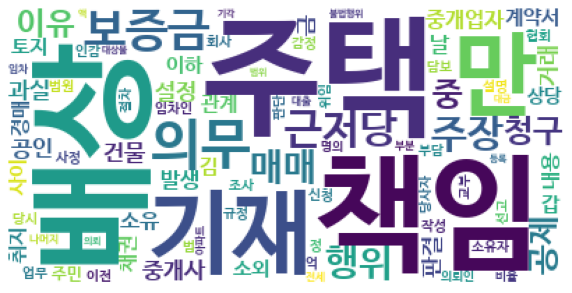

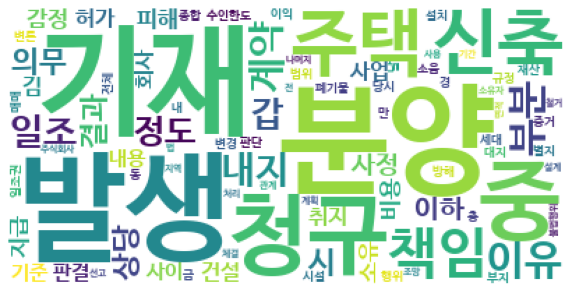

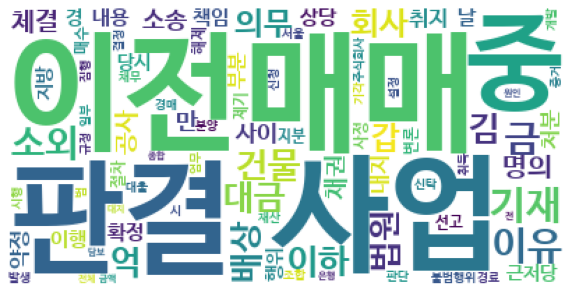

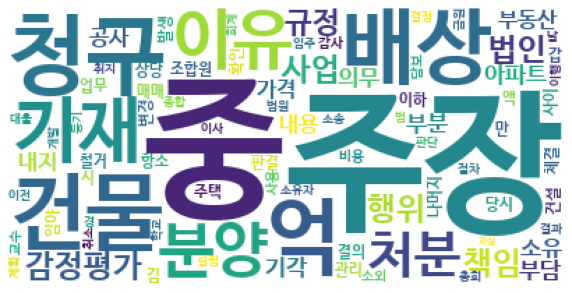

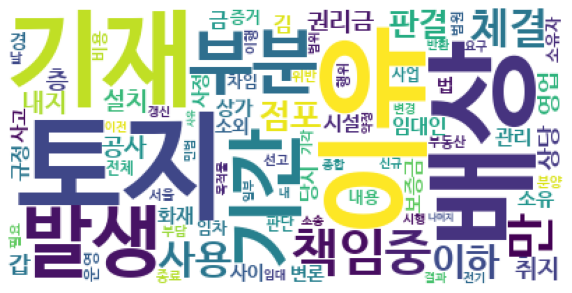

In [71]:
for idx,nouns in enumerate(nouns_entire):
    num_top_nouns = 100
    nouns_counter = Counter(nouns)
    top_nouns = dict(nouns_counter.most_common(num_top_nouns)[15:])
#     print(top_nouns)
    wc = WordCloud(background_color="white", font_path='/Users/byeonghyeon/Documents/GitHub/IndustrialSystemsEngineering_Project/font/NanumBarunGothicBold.ttf')
    wc.generate_from_frequencies(top_nouns)
    # World
    # 많이 나타나는 단어일수록 크게 나타남
    figure = plt.figure()
    figure.set_size_inches(10, 10)
    ax = figure.add_subplot(1, 1, 1)
    ax.axis("off")
    ax.imshow(wc)
    plt.savefig('{}cluster.png'.format(idx+1))
    print(dict(nouns_counter.most_common(num_top_nouns)[15:100]))

In [ ]:
cosine_result = []
for x in range(len(info_df)):
    tmp = []
    for y in range(len(info_df)):
        tmp.append(cosine_similarity(X[x], X[y])[0][0])
    print(x)
    cosine_result.append(tmp)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

In [116]:
# 모든 조에 해당하는 cosine similarity 결과 값을
# DataFrame 형태로 변환
cosine_result_df = pd.DataFrame(cosine_result)
cosine_result_df

,0,1,2,3,4,5,6,7,8,9,...,998,999,1000,1001,1002,1003,1004,1005,1006,1007
0,1.000000,0.218817,0.129549,0.196631,0.126354,0.128783,0.181523,0.148067,0.169310,0.247952,...,0.131221,0.090592,0.083682,0.092631,0.068195,0.089646,0.081046,0.088136,0.034304,0.035866
1,0.218817,1.000000,0.186487,0.127554,0.178898,0.166218,0.222885,0.165872,0.162296,0.218212,...,0.141143,0.087747,0.064555,0.082535,0.145144,0.068794,0.092517,0.085853,0.019263,0.032606
2,0.129549,0.186487,1.000000,0.097434,0.551993,0.188712,0.178683,0.128539,0.132881,0.113910,...,0.084355,0.036710,0.075496,0.062522,0.084707,0.072920,0.057516,0.046548,0.015142,0.066192
3,0.196631,0.127554,0.097434,1.000000,0.083238,0.116493,0.127438,0.095993,0.125395,0.170655,...,0.041743,0.070989,0.062893,0.095116,0.073744,0.090419,0.136273,0.047131,0.113322,0.038526
4,0.126354,0.178898,0.551993,0.083238,1.000000,0.140848,0.138239,0.107815,0.087456,0.078863,...,0.087727,0.028177,0.075692,0.056903,0.097425,0.055231,0.066539,0.058447,0.013401,0.032763
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1003,0.089646,0.068794,0.072920,0.090419,0.055231,0.106287,0.107949,0.102380,0.069009,0.058269,...,0.047295,0.074970,0.028169,0.063814,0.068687,1.000000,0.026394,0.075904,0.055160,0.038009
1004,0.081046,0.092517,0.057516,0.136273,0.066539,0.053801,0.062997,0.063445,0.059069,0.060069,...,0.072691,0.117832,0.116573,0.343609,0.061837,0.026394,1.000000,0.069973,0.347804,0.008564
1005,0.088136,0.085853,0.046548,0.047131,0.058447,0.122246,0.046991,0.043807,0.026880,0.039184,...,0.034589,0.041934,0.026774,0.051486,0.055382,0.075904,0.069973,1.000000,0.020783,0.007663
1006,0.034304,0.019263,0.015142,0.113322,0.013401,0.025758,0.096999,0.055449,0.030000,0.058100,...,0.033540,0.054524,0.147149,0.339744,0.033566,0.055160,0.347804,0.020783,1.000000,0.026550


In [117]:
network = nx.from_numpy_matrix(cosine_result_df.loc[0:10,0:10].to_numpy())
list(network.adjacency())


[(0,
  {0: {'weight': 1.0000000000000002},
   1: {'weight': 0.21881670615396784},
   2: {'weight': 0.12954859240124625},
   3: {'weight': 0.19663095713053266},
   4: {'weight': 0.12635439304120016},
   5: {'weight': 0.12878270079098036},
   6: {'weight': 0.18152252897093898},
   7: {'weight': 0.14806715539881066},
   8: {'weight': 0.16930965647212287},
   9: {'weight': 0.24795208643314928},
   10: {'weight': 0.17221275093959218}}),
 (1,
  {0: {'weight': 0.21881670615396784},
   1: {'weight': 1.0},
   2: {'weight': 0.18648701170208054},
   3: {'weight': 0.1275544773407609},
   4: {'weight': 0.17889792527371462},
   5: {'weight': 0.16621838553455281},
   6: {'weight': 0.2228845582517919},
   7: {'weight': 0.16587173366190217},
   8: {'weight': 0.16229579160427243},
   9: {'weight': 0.21821163567624227},
   10: {'weight': 0.23896659460316197}}),
 (2,
  {0: {'weight': 0.12954859240124625},
   1: {'weight': 0.18648701170208054},
   2: {'weight': 1.0},
   3: {'weight': 0.09743417729177029},


In [165]:
import networkx as nx
def draw_graphs(sim_matrix,result_index):
    nx_graph = nx.from_numpy_array(sim_matrix)
    plt.figure(figsize=(10, 10))
    pos = nx.spring_layout(nx_graph)
    option = {
    'node_color' : 'lightblue',
    'node_size' : 1000}
    nx.Graph().add_nodes_from(result_index)
    nx.draw(nx_graph, with_labels=True, font_weight='bold', **option)
    nx.draw_networkx_edge_labels(nx_graph,pos,font_color='red')
    plt.show()

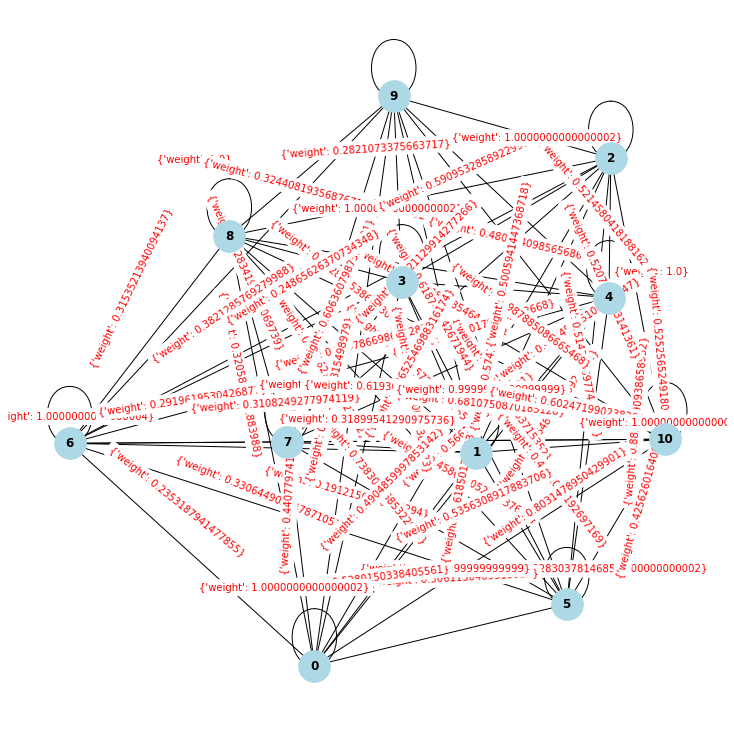

In [166]:
result_index = []
for i in sorted_cosine_dic[0:11]:
    result_index.append(info_df[info_df["ID"] == i[0]].index[0])
draw_graphs(cosine_result_df.iloc[result_index][result_index].to_numpy(),result_index)

In [158]:
cosine_result_df.loc[0:10,0:10]

,0,1,2,3,4,5,6,7,8,9,10
0,1.000000,0.218817,0.129549,0.196631,0.126354,0.128783,0.181523,0.148067,0.169310,0.247952,0.172213
1,0.218817,1.000000,0.186487,0.127554,0.178898,0.166218,0.222885,0.165872,0.162296,0.218212,0.238967
2,0.129549,0.186487,1.000000,0.097434,0.551993,0.188712,0.178683,0.128539,0.132881,0.113910,0.588716
3,0.196631,0.127554,0.097434,1.000000,0.083238,0.116493,0.127438,0.095993,0.125395,0.170655,0.101340
4,0.126354,0.178898,0.551993,0.083238,1.000000,0.140848,0.138239,0.107815,0.087456,0.078863,0.642200
5,0.128783,0.166218,0.188712,0.116493,0.140848,1.000000,0.159088,0.138512,0.173661,0.136934,0.184864
6,0.181523,0.222885,0.178683,0.127438,0.138239,0.159088,1.000000,0.332979,0.141667,0.232622,0.190279
7,0.148067,0.165872,0.128539,0.095993,0.107815,0.138512,0.332979,1.000000,0.114254,0.177589,0.158562
8,0.169310,0.162296,0.132881,0.125395,0.087456,0.173661,0.141667,0.114254,1.000000,0.172282,0.109816
9,0.247952,0.218212,0.113910,0.170655,0.078863,0.136934,0.232622,0.177589,0.172282,1.000000,0.115810


In [134]:

cosine_result_df.iloc[result_index][result_index]


,1007,873,874,218,259,875,622,157,275,297,240
1007,1.000000,0.393234,0.386296,0.345622,0.324408,0.320588,0.315352,0.283420,0.282865,0.282107,0.277698
873,0.393234,1.000000,0.882939,0.564848,0.480554,0.566155,0.219787,0.521017,0.483453,0.521458,0.525257
874,0.386296,0.882939,1.000000,0.494503,0.452975,0.506115,0.191215,0.458648,0.432201,0.514353,0.425626
218,0.345622,0.564848,0.494503,1.000000,0.615081,0.528015,0.330645,0.738306,0.618501,0.574150,0.803148
259,0.324408,0.480554,0.452975,0.615081,1.000000,0.443222,0.382129,0.606361,0.618745,0.590953,0.598789
875,0.320588,0.566155,0.506115,0.528015,0.443222,1.000000,0.235319,0.440780,0.490486,0.365255,0.535631
622,0.315352,0.219787,0.191215,0.330645,0.382129,0.235319,1.000000,0.291962,0.310825,0.248656,0.318995
157,0.283420,0.521017,0.458648,0.738306,0.606361,0.440780,0.291962,1.000000,0.619308,0.572113,0.681075
275,0.282865,0.483453,0.432201,0.618501,0.618745,0.490486,0.310825,0.619308,1.000000,0.500594,0.602472
297,0.282107,0.521458,0.514353,0.574150,0.590953,0.365255,0.248656,0.572113,0.500594,1.000000,0.520769


In [133]:
network = nx.from_numpy_matrix(cosine_result_df.iloc[result_index][result_index].to_numpy())
list(network.adjacency())

[(0,
  {0: {'weight': 1.0},
   1: {'weight': 0.3932336320458871},
   2: {'weight': 0.3862957247339755},
   3: {'weight': 0.3456218427727562},
   4: {'weight': 0.3244081935687671},
   5: {'weight': 0.3205876001883988},
   6: {'weight': 0.31535213940094137},
   7: {'weight': 0.2834198066069739},
   8: {'weight': 0.2828645386563019},
   9: {'weight': 0.2821073375663717},
   10: {'weight': 0.27769817854644424}}),
 (1,
  {0: {'weight': 0.3932336320458871},
   1: {'weight': 1.0},
   2: {'weight': 0.8829390938658932},
   3: {'weight': 0.5648477296924991},
   4: {'weight': 0.48055409856568665},
   5: {'weight': 0.5661554046958631},
   6: {'weight': 0.21978669867128134},
   7: {'weight': 0.5210170994882668},
   8: {'weight': 0.48345345106689647},
   9: {'weight': 0.5214580418188162},
   10: {'weight': 0.525256524918006}}),
 (2,
  {0: {'weight': 0.3862957247339755},
   1: {'weight': 0.8829390938658932},
   2: {'weight': 1.0000000000000002},
   3: {'weight': 0.49450283037814685},
   4: {'weight':